Notebook 6: K-Means Clustering
==============================

## Goals for learning
In this assignment, we will:
1) Perform a deep-dive into the **K-Means** clustering algorithm, with some enhancements.
2) Practice working with the array-oriented programming paradigm.
3) Gain experience working with off-the-shelf machine learning and data analysis libraries.

## Instructions
* Read through the notebook.
* Answer any plain text questions (replace cell content, "YOUR RESPONSE HERE", with your response).
* Insert your code within the code blocks marked with the comments "# START your code here" and "# STOP your code here".
* Do not use loops, iteration, or recursion in any of the code cells (except where explicitly allowed).
* Do not use any "Generative AI" tools or assistants in the creation of your solutions.
* Do not import ot use any libraries other than those already imported outside the "# START your code here" and "# STOP your code here" blocks.
* Run all cells to make sure your code works and you see reasonable results.
    * All code cells should have output indicating the results of the last run when the notebook is submitted.
    * If there are errors, or if a code cell does not have output as submittted, points will be deducted.

## Submission details
* Due: Monday 10/13, 11:59 PM
* [Submission instructions](https://www.cs.oswego.edu/~agraci2/csc461/submission_instructions.html)

## Notebook premise
You are an ML engineer at a real estate company. You are tasked with creating a model for finding groups of similar apartments. This model is going to be used for a new feature, which recommends apartments to customers based on other apartments that they liked or shared.

## Loading the data

The data set we will be using is from the University of California Irvine's ML Lab, and contains information on 10,000 apartment rental ads.

[Apartment for rent classified. (2019). UCI Machine Learning Repository. https://doi.org/10.24432/C5X623.](https://archive.ics.uci.edu/dataset/555/apartment+for+rent+classified)

Note: A copy of this dataset is also cached on Brightspace.

In [1]:
# START your code here
     
# Path where you downloaded the training and test data
DATASET_ROOT_DIR =  '' # Please edit with your dataset path

# STOP your code here

In [2]:
import os.path
import numpy
import pandas

# Read in the database
APARTMENT_DATA_FILENAME = "apartments_for_rent_classified_10K.csv"
assert os.path.isfile(os.path.join(DATASET_ROOT_DIR, APARTMENT_DATA_FILENAME)), "Could not find database file at: {}".format(DATASET_ROOT_DIR)
dataframe = pandas.read_csv(os.path.join(DATASET_ROOT_DIR, APARTMENT_DATA_FILENAME), sep=';', encoding='cp1252')

The code cell below will load and transform the data.

**Please only run this cell once**. I have put all random draws in this cell, so as long as you do not re-run it without restarting the kernel, your results should be deterministic.

In [3]:
seed = 42
numpy.random.seed(seed) 

# Check how many rows and columns are in the loaded data
print(dataframe.shape)

# Add room for clusters, but zero it out
dataframe['clusters'] = numpy.zeros((dataframe.shape[0],))

# Cherry-pick a few features
dataframe_latlon = dataframe[['longitude', 'latitude', 'clusters']]

# Randomly select 10 centroids
centroids_latlon_rand = dataframe_latlon.sample(n=10).reset_index().drop(columns=['index'])

(10000, 22)


In [4]:
# emma checky check
print(dataframe.columns.tolist(),'\n--------------------------------------------------------')
print(dataframe_latlon.head())

['id', 'category', 'title', 'body', 'amenities', 'bathrooms', 'bedrooms', 'currency', 'fee', 'has_photo', 'pets_allowed', 'price', 'price_display', 'price_type', 'square_feet', 'address', 'cityname', 'state', 'latitude', 'longitude', 'source', 'time', 'clusters'] 
--------------------------------------------------------
   longitude  latitude  clusters
0   -76.9861   38.9057       0.0
1   -87.6621   37.9680       0.0
2   -77.0816   38.8910       0.0
3  -122.3275   47.6160       0.0
4   -77.1055   38.8738       0.0


## Visualizing clusters

The following cell uses the [seaborn](https://seaborn.pydata.org/) statistical data visualization library to plot the points in 2D [Euclidean space](https://en.wikipedia.org/wiki/Euclidean_space), color-coded by cluster.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the data points in Euclidean space, color-code by cluster
def DrawClusters(dataframe):
    sns.relplot(data=dataframe, x=dataframe.columns[0], y=dataframe.columns[1], hue='clusters', aspect=1.61, palette="tab10")
    plt.show()

<u>Note</u>: There is a [known bug](https://github.com/matplotlib/matplotlib/issues/26290) with MatPlotlib that affects the Seaborn library, and may result in the following warning. If you see this, feel free to just ignore it:
    
> /usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: 
> UserWarning: The figure layout has changed to tight
> self._figure.tight_layout(*args, **kwargs)

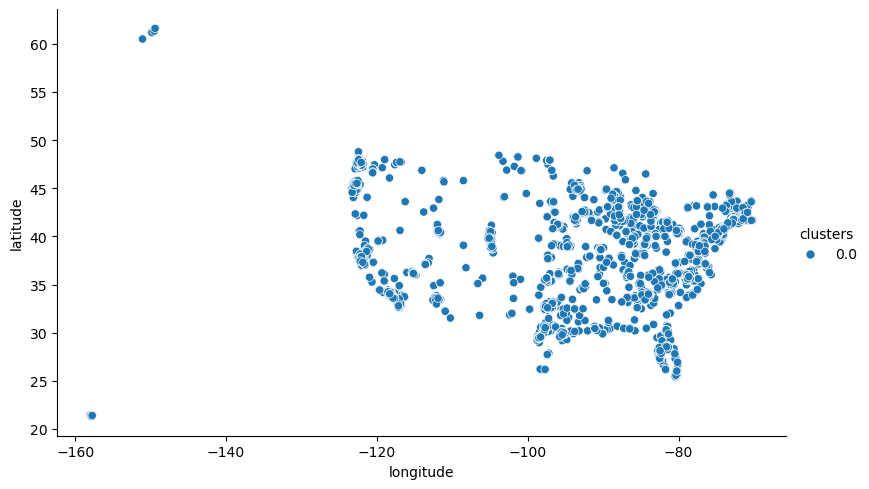

In [6]:
# Try out our visualization function before cluster assignment
DrawClusters(dataframe_latlon)

## Distance metrics

In the code cell below are some **helper functions** for computing distance. Specifically, we will be using the [Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance):

$$d(p,q)=\sqrt{\sum_i^{\text{features}}{(p_i - q_i)^2}}$$

In [7]:
# Calculates the distance between two points "p" and "q"
def Distance(p, q):
    distance = None
    
    '''
    TO DO: 
    1. Do not consider previous cluster assignment when calculating distance (how can you clean your data?)
    2. Implement the Euclidean Distance equation
    '''
    # START your code here
    p_clean = p[['longitude', 'latitude']].values
    q_clean = q[['longitude', 'latitude']].values
    # print('p\n',p_clean,'\n--------------------------------------------------------------')
    # print('q\n',q_clean,'\n--------------------------------------------------------------')
    # print('p-q\n',p_clean-q_clean,'\n--------------------------------------------------------------')
    # print('p-q^2\n',numpy.square(p_clean - q_clean),'\n--------------------------------------------------------------')
    # print('sum of p-q^2\n',numpy.sum(numpy.square(p_clean - q_clean)),'\n--------------------------------------------------------------')
    # print('dist\n',numpy.sqrt(numpy.sum(numpy.square(p_clean - q_clean))),'\n--------------------------------------------------------------')
    distance = numpy.sqrt(numpy.sum(numpy.square(p_clean - q_clean)))
    # STOP your code here
    
    return distance

# Calculates the centroid with the minimum distance from the point
def MinDistance(point, centroids):
    min_idx = None

    '''
    TO DO: 
    1. Get all distances (from the point to each of the centroids)
    2. Get the index of the minimum distance (closest centroid)
    '''
    # START your code here
    distances = numpy.sqrt(numpy.sum(numpy.square(centroids - point), axis=1))
    min_idx = numpy.argmin(distances)
    # STOP your code here
    
    return min_idx

In [8]:
# Checkpoint
first_point = dataframe_latlon.iloc[0]
first_centroid = centroids_latlon_rand.copy().iloc[0]
first_centroid.clusters = 100
distance = Distance(first_point, first_centroid)
checked_decimals=5
numpy.testing.assert_almost_equal(distance, 3.425863051845484, decimal=checked_decimals, verbose=True)

min_distance = MinDistance(first_point, centroids_latlon_rand)
assert min_distance == 9, "Unexpected closest centroid assigned: {}, expected 9.".format(min_distance)
print("Done.")

Done.


## Evaluating cluster quality

We will be using the [sum of squared errors](https://hlab.stanford.edu/brian/error_sum_of_squares.html) (SSE) metric for evaluating the quality of our clusters:

$$\text{SSError}(X, y)={\sum^{\text{points}}_i{\text{error}(X_i, y)^2}}$$

<u>Note</u>: In our case, the **error** between the points and their centroid is the **Euclidean Distance**.

<u>Implementation Hint</u>: Look at the [DataFrame.apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) function. Can you use it to reuse your "Distance" function from above?

In [9]:
# Calculates the SSE for a single cluster (from all points to the centroid)
def SSE(points, centroid):
    sse = None
    
    '''
    TO DO: Calculate the SSE
    '''
    # START your code here
    distances = points.apply(lambda row: Distance(row, centroid), axis=1)
    sse = numpy.sum(numpy.square(distances))
    # STOP your code here
    
    return sse

# Calculates the SSE accross all clusters
def AllSSE(points, centroids):
    all_sse = 0
    for i in range(0, centroids.shape[0]):
        cluster = points.where(points["clusters"] == i).dropna()
        all_sse += SSE(cluster, centroids.iloc[i])
    return all_sse

In [10]:
# Checkpoint
first_centroid = centroids_latlon_rand.copy().iloc[0]
first_centroid.clusters = 100
sse = SSE(dataframe_latlon, first_centroid)
checked_decimals=5
numpy.testing.assert_almost_equal(sse, 5294616.021380349, decimal=checked_decimals, verbose=True)

all_sse = AllSSE(dataframe_latlon, centroids_latlon_rand)
numpy.testing.assert_almost_equal(all_sse, 5294616.021380349, decimal=checked_decimals, verbose=True)
print("Done.")

Done.


## The K-Means Algorithm

#### Steps
1) Randomly select K data points, and use them to initialize the **centroids**.
2) Loop until the **convergence criterion** is satisfied:
    * Assign each data point to the **closest** centroid (according to the **distance function**, in the case Euclidean distance).
    * Compute the new **centroid** (mean point) for each cluster (mean for each individual feature $x_i$).
    
#### Convergence Criterion
* Clusters become **stable**, data points stop changing clusters.
* Or until the difference in assignments becomes very small (some threshold)
* Or using a max number of iterations (e.g. T)

#### Implementation
In the code cell below, implement the indicated steps.

<u>Implementation Hints</u>:

* Look at the [DataFrame.apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) function. Are there any **helper functions** from above that you can use?
* Look at the [DataFrame.groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) function. By which feature can you group your datapoints to help accomplish this task?
* You can use the SSE to help detect convergence, but [be careful with your floating point comparisons](https://docs.python.org/3/tutorial/floatingpoint.html). 

In [11]:
# Run the K-Means algorithm
def KMeans(orig_dataframe, orig_centroids, max_iterations=15):
    dataframe = orig_dataframe.copy()
    centroids = orig_centroids.copy()
    allowable_convergence_error = 0.001 # Can be used to compare floats
    converged = False
    iterations = 0
    
    # Print the initial SSE
    sse = AllSSE(dataframe, centroids)
    print("Iteration: {}, SSE: {}".format(iterations, sse))
    print(centroids)
    while (converged == False):
        # Avoid running for too long if something went wrong
        if iterations == max_iterations:
            break
            
        iterations += 1
        
        '''
        TO DO: 
        1. Assign each point to a cluster according to its distance from the closest centroid
           * The result will be an array of indexes (0-k), one element per row in the dataframe
        2. Calculate new centroids (k synthetic data points)
        3. Check for convergence
           * Hint: One option is to use SSE to determine convergence
           
        Implementation hint: 
        Use the DrawClusters(dataframe) method to visualize cluster assignements at each iteration.
        '''
        # START your code here
        dataframe["clusters"] = dataframe.apply(lambda row: MinDistance(row, centroids), axis=1) # 1- assigning points to clusters
        
        new_centroids = dataframe.groupby("clusters")[["longitude", "latitude"]].mean().reset_index() #2 - new centroids
        centroids = new_centroids[["longitude", "latitude"]] # 2.1 - reassign pt 1
        centroids["clusters"] = new_centroids["clusters"] #2.2 - reassign pt 2
        
        new_sse = AllSSE(dataframe, centroids)
        if abs(sse - new_sse) < allowable_convergence_error: # 4- check convergence with SSE
            converged = True
        sse = new_sse
        # STOP your code here
        
        # Print the SSE for this iteration
        print("Iteration: {}, SSE: {}".format(iterations, sse))
        
    return dataframe

## Geographic clustering with K-Means

You decide that apartment hunters who look at an apartment in one region might want to see other apartments in that same region, so you use the "latitude" and "longitude" features to cluster your apartment data.

<u>Note</u>: Yes, this is a bit of a contrived example, and there are better ways to filter by location, but this displays nicely, so we're going to pretend that this is reasonable.

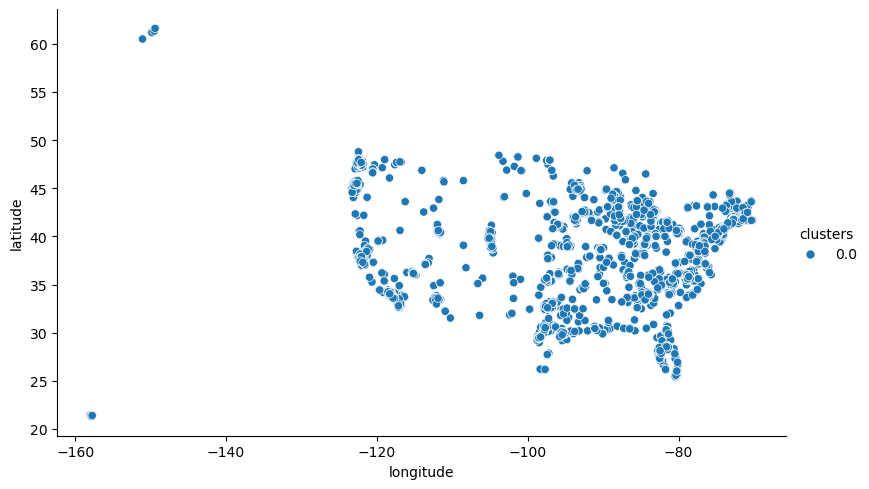

KeyboardInterrupt: 

In [14]:
%%time
# ^This will display how long it takes to execute this cell

# Draw the clusters before
DrawClusters(dataframe_latlon)

# Randomly select the initial centroids
k=3
centroids_latlon_rand_k3 = centroids_latlon_rand.iloc[0:k]
clusters = KMeans(dataframe_latlon, centroids_latlon_rand_k3)

# Draw the clusters after
DrawClusters(clusters)

print("Done.")

##### **Question:** How many iterations did it take to converge? (K-Means)

##### **Question:** What is the overall SSE for the resulting clusters? (K-Means)

## Geographic clustering with K-Means++

You have heard about an enhancement to K-Means, where the initial centriod selection is a bit more sophisticated.

### Goal
The goal of [**K-means++**](https://en.wikipedia.org/wiki/K-means%2B%2B) is to improve the initialization of the centroids for the K-means clustering algorithm.

### Steps
1) Randomly select a datapoint for the first centroid. 
2) Loop (for each other centroid until K):
    * Select the datapoint with the greatest distance from each other selected centroid.
3) Continue with K-Means.

In [25]:
def AllDistances(points, centroid):
    distances = None

    '''
    TO DO: 
    1. Calculate the distances from each point to the centroid
       * Hint: Re-use your Distance method from before
    '''
    # START your code here
    points_clean = points.drop(columns=['clusters']).values
    centroid_clean = centroid.drop(labels='clusters').values
    distances = numpy.sqrt(numpy.sum(numpy.square(points_clean - centroid_clean), axis=1))
    distances = pandas.Series(distances, index=points.index)
    # STOP your code here
        
    return distances
    
# Calculates the point with the maximum distance from the existing centroids
def MaxDistance(points, centroids):

    # Get all distances (from each centroid to each of the points)
    distances = AllDistances(points, centroids.iloc[0])
    for i in range(1, centroids.shape[0]):
        distances += AllDistances(points, centroids.iloc[i])
    distances.reset_index().drop(columns=['index'])
    
    # Get the point with the maximum distance (farthest point)
    max_idx = distances.idxmax()
    
    return max_idx

In [26]:
# Checkpoint
centroids_latlon_rand_kpp = centroids_latlon_rand.copy().iloc[0:2].reset_index(drop=True)
max_distance = MaxDistance(dataframe_latlon, centroids_latlon_rand)
numpy.testing.assert_equal(max_distance, 3897, verbose=True)
print("Done.")

Done.


centroids_latlon_rand_kpp:    longitude  latitude  clusters
0  -118.3527   33.9136       0.0
1   -70.3559   43.6846       0.0
2  -158.0221   21.4476       0.0
Iteration: 0, SSE: 8537050.476940429
   longitude  latitude  clusters
0  -118.3527   33.9136       0.0
1   -70.3559   43.6846       0.0
2  -158.0221   21.4476       0.0
Iteration: 1, SSE: 1059911.3072760613
Iteration: 2, SSE: 1056722.6258216512
Iteration: 3, SSE: 1055420.4191638962
Iteration: 4, SSE: 1055395.9838779508
Iteration: 5, SSE: 1055395.9838779508


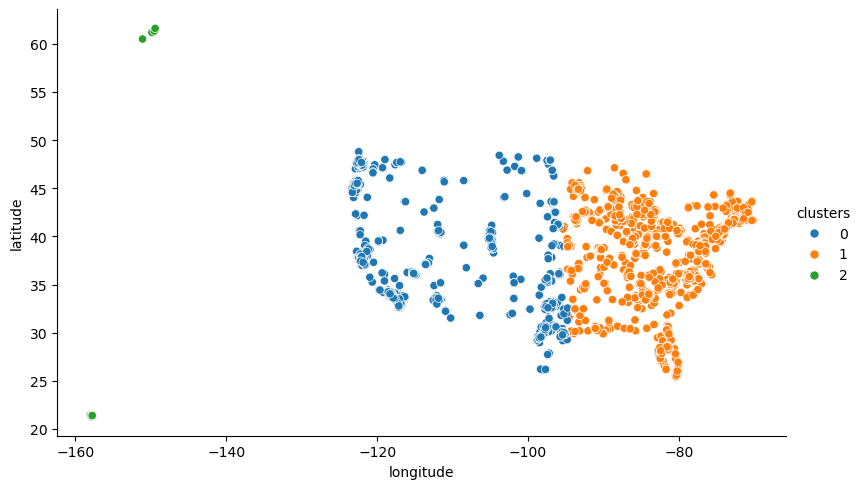

Done.
CPU times: total: 2min 47s
Wall time: 3min 17s


In [27]:
%%time
# ^This will display how long it takes to execute this cell

k=3

# Randomly select the first initial centroid
centroids_latlon_rand_kpp = centroids_latlon_rand.iloc[8:9].reset_index(drop=True)

# For each subsequent centroid, pick the point that is the fathest from all previously selected centroids
while centroids_latlon_rand_kpp.shape[0] < k:
    max_idx = MaxDistance(dataframe_latlon, centroids_latlon_rand_kpp)
    max_dist = dataframe_latlon.iloc[max_idx:max_idx+1].reset_index(drop=True)
    centroids_latlon_rand_kpp = pandas.concat([centroids_latlon_rand_kpp, max_dist], axis=0, ignore_index=True)
print("centroids_latlon_rand_kpp: {}".format(centroids_latlon_rand_kpp))
    
# Other than initial centroid selection, the rest of the algorithm is the same as K-means
clusters = KMeans(dataframe_latlon, centroids_latlon_rand_kpp)

# Draw the clusters after
DrawClusters(clusters)

print("Done.")

##### **Question:** How many iterations did it take to converge? (K-Means++)

##### **Question:** What is the overall SSE for the resulting clusters? (K-Means++)

##### **Question:** Which algorithm converged more quickly? (K-Means or K-Means++)

##### **Question:** Which algorithm converged on higher quality clusters? (K-Means or K-Means++)

## Adjusting the value of K

Previously, we set the value of K to 3. What happens if we try a different value, like 5?

centroids_latlon_rand_kpp:    longitude  latitude  clusters
0  -118.3527   33.9136       0.0
1   -70.3559   43.6846       0.0
2  -158.0221   21.4476       0.0
3  -151.0806   60.4923       0.0
4   -70.1916   41.6713       0.0
Iteration: 0, SSE: 8537050.476940429
   longitude  latitude  clusters
0  -118.3527   33.9136       0.0
1   -70.3559   43.6846       0.0
2  -158.0221   21.4476       0.0
3  -151.0806   60.4923       0.0
4   -70.1916   41.6713       0.0
Iteration: 1, SSE: 968968.6582827313
Iteration: 2, SSE: 849828.9158485797
Iteration: 3, SSE: 718893.0286959608
Iteration: 4, SSE: 479884.6236988846
Iteration: 5, SSE: 451006.3027341481
Iteration: 6, SSE: 445515.7148081611
Iteration: 7, SSE: 442109.9938156418
Iteration: 8, SSE: 438090.335321113
Iteration: 9, SSE: 435857.6533606065
Iteration: 10, SSE: 435495.241838787
Iteration: 11, SSE: 435485.75170103344
Iteration: 12, SSE: 435485.75170103344


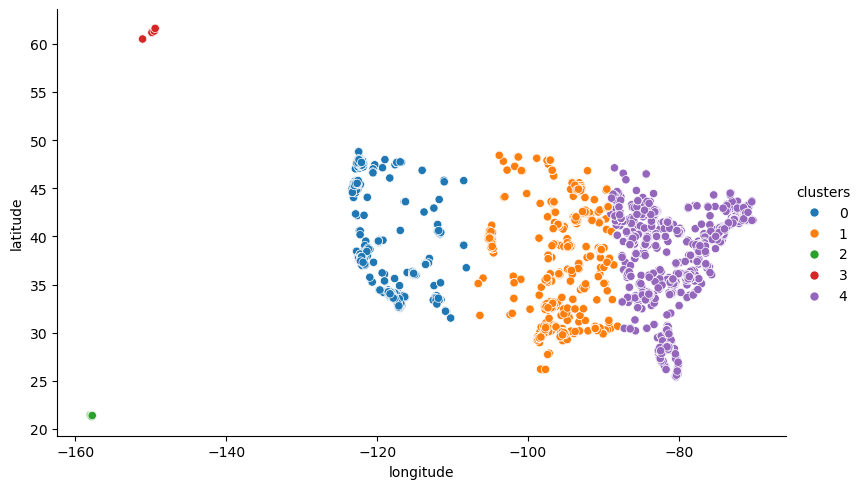

CPU times: total: 6min 35s
Wall time: 8min 58s


In [29]:
%%time
# ^This will display how long it takes to execute this cell

# START your code here
k = 5
# STOP your code here

# Randomly select the first initial centroid
centroids_latlon_rand_kpp = centroids_latlon_rand.iloc[8:9].reset_index(drop=True)

# For each subsequent centroid, pick the point that is the fathest from all previously selected centroids
while centroids_latlon_rand_kpp.shape[0] < k:
    max_idx = MaxDistance(dataframe_latlon, centroids_latlon_rand_kpp)
    max_dist = dataframe_latlon.iloc[max_idx:max_idx+1].reset_index(drop=True)
    centroids_latlon_rand_kpp = pandas.concat([centroids_latlon_rand_kpp, max_dist], axis=0, ignore_index=True)
print("centroids_latlon_rand_kpp: {}".format(centroids_latlon_rand_kpp))
    
# Other than initial centroid selection, the rest of the algorithm is the same as K-means
clusters = KMeans(dataframe_latlon, centroids_latlon_rand_kpp)

# Draw the clusters after
DrawClusters(clusters)

##### **Question:** How many iterations did it take to converge? (K-Means++, k=5)

##### **Question:** What is the overall SSE for the resulting clusters? (K-Means++, k=5)

##### **Question:** Which value of K converged more quickly? (3 or 5)

##### **Question:** Which value of K converged on higher quality clusters? (3 or 5)

##### **Question:** The apartments in Hawaii and Alaska are outliers in this dataset. What k-Means variant(s) did we discuss in lecture that are designed to address the handling of outliers?

In [ ]:
Congratulations, you have reached the end of this notebook!